# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [160]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [161]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

N_SAMPLES = 1000

X, y = make_moons(n_samples= N_SAMPLES, 
                  noise = 0.1,
                  random_state = RANDOM_SEED)

In [162]:
# Turn data into a DataFrame
import pandas as pd

moons = pd.DataFrame({'X1': X[:, 0], 
                      'X2': X[:, 1], 
                      'label': y})

moons.head(10)

,X1,X2,label
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0
5,0.613706,-0.242369,1
6,0.286495,-0.201277,1
7,-0.056104,0.477079,1
8,1.604217,-0.303541,1
9,0.709641,0.858867,0


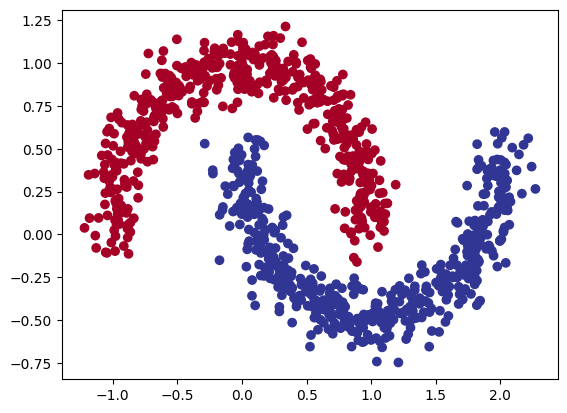

In [163]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0], 
            y = X[:, 1], 
            c = y, 
            cmap = plt.cm.RdYlBu);

In [164]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = RANDOM_SEED)

print(f"Length, shape and data type of X: {len(X), X.shape, X.dtype} | Length, shape and data type of y : {len(y), y.shape, y.dtype} | Length of train data: {len(X_train), len(y_train)} | Length of test data: {len(X_test), len(y_test)}")

Length, shape and data type of X: (1000, torch.Size([1000, 2]), torch.float32) | Length, shape and data type of y : (1000, torch.Size([1000]), torch.float32) | Length of train data: (800, 800) | Length of test data: (200, 200)


## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [165]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features = 2, out_features = 8),
          nn.ReLU(),
          nn.Linear(in_features = 8, out_features = 8),
          nn.ReLU(),
          nn.Linear(in_features = 8, out_features = 1)
      ).to(device)

    def forward(self, x):
        return self.linear_layer_stack(x)

# Instantiate the model
model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [166]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params = model_0.parameters(), 
                            lr = 0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [167]:
# What's coming out of our model?
model_0.eval()
with torch.inference_mode():
# logits (raw outputs of model)
  untrained_y_logits = model_0(X_test.to(device)).squeeze()

print(f"Logits: {untrained_y_logits[:5]}")

# Prediction probabilities
untrained_y_pred_probs = torch.sigmoid(untrained_y_logits)
print(f"Pred probs: {untrained_y_pred_probs[:5]}")

# Prediction labels
untrained_y_pred_labels = torch.round(untrained_y_pred_probs)
print(f"Pred labels: {untrained_y_pred_labels[:5]}")

Logits: tensor([-0.0983, -0.2292, -0.1983, -0.2040, -0.2930], device='cuda:0')
Pred probs: tensor([0.4755, 0.4429, 0.4506, 0.4492, 0.4273], device='cuda:0')
Pred labels: tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [168]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes = 2).to(device) # send accuracy function to device
acc_fn(untrained_y_pred_labels, y_test.to(device))

tensor(0.5000, device='cuda:0')

In [169]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1001

# Send data to the device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  y_logits = model_0(X_train).squeeze()

  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
  optimizer.step()

  ### Testing
  model_0.eval() 
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0(X_test).squeeze()
    
    # Turn the test logits into prediction labels
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(y_test, test_pred)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.7120 | Acc: 0.50 | Test loss: 0.7053 | Test acc: 0.50
Epoch: 100 | Loss: 0.3676 | Acc: 0.84 | Test loss: 0.3796 | Test acc: 0.82
Epoch: 200 | Loss: 0.2519 | Acc: 0.88 | Test loss: 0.2490 | Test acc: 0.88
Epoch: 300 | Loss: 0.2352 | Acc: 0.89 | Test loss: 0.2271 | Test acc: 0.89
Epoch: 400 | Loss: 0.2193 | Acc: 0.90 | Test loss: 0.2091 | Test acc: 0.91
Epoch: 500 | Loss: 0.1945 | Acc: 0.92 | Test loss: 0.1831 | Test acc: 0.93
Epoch: 600 | Loss: 0.1582 | Acc: 0.93 | Test loss: 0.1459 | Test acc: 0.94
Epoch: 700 | Loss: 0.1164 | Acc: 0.96 | Test loss: 0.1041 | Test acc: 0.98
Epoch: 800 | Loss: 0.0814 | Acc: 0.98 | Test loss: 0.0702 | Test acc: 0.99
Epoch: 900 | Loss: 0.0583 | Acc: 0.99 | Test loss: 0.0485 | Test acc: 1.00
Epoch: 1000 | Loss: 0.0440 | Acc: 0.99 | Test loss: 0.0355 | Test acc: 1.00


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [170]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

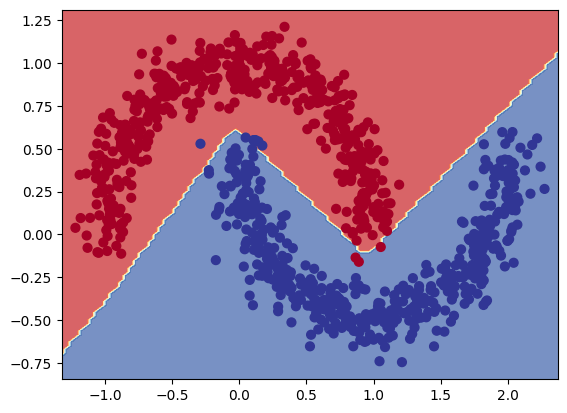

In [171]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_0, X, y)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [172]:
# Create a straight line tensor


In [173]:
# Test torch.tanh() on the tensor and plot it


In [174]:
# Replicate torch.tanh() and plot it


## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

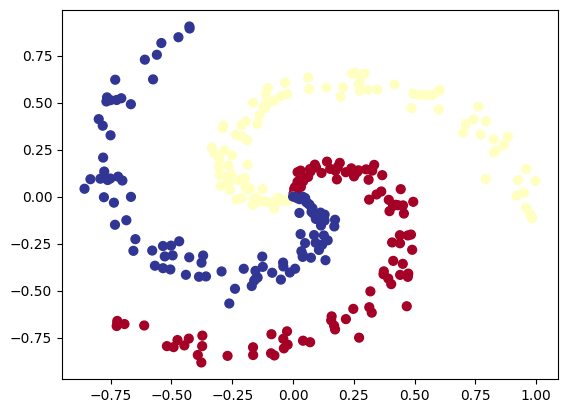

In [175]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [176]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split


In [177]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

In [178]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module



# Instantiate model and send it to device


In [179]:
# Setup data to be device agnostic

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")

print("Pred probs:")

print("Pred labels:")

Logits:
Pred probs:
Pred labels:


In [180]:
# Setup loss function and optimizer
# loss_fn =
# optimizer = 

In [181]:
# Build a training loop for the model

# Loop over data


  ## Training
  
  # 1. Forward pass
  

  # 2. Calculate the loss
  
  
  # 3. Optimizer zero grad
  

  # 4. Loss backward
  

  # 5. Optimizer step
  

  ## Testing
  

    # 1. Forward pass
    
    # 2. Caculate loss and acc
    
  # Print out what's happening every 100 epochs
  

In [182]:
# Plot decision boundaries for training and test sets
